# 02_clean_eda (housing / CSV)
**Authors**: <fill names> | **Owner**: <name> | **Reviewer**: <name> | **Date**: 2025-11-07

**Purpose:** Clean + EDA using intermediate_data/housing_all.csv

> These notebooks assume the first ingest saved **CSV** outputs into `intermediate_data/` (not Parquet).
> Paths used:
> - Raw CSV: `price_paid_records/price_paid_records.csv`
> - Combined CSV: `intermediate_data/housing_all.csv`
> - Optional partitioned by year: `intermediate_data/partitioned_csv/year=YYYY.csv`


In [1]:
!pip install pandas matplotlib numpy --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INT_DIR = Path("../../data\intermediate\housing")
PROC_DIR = Path("../../data/housing")
PROC_DIR.mkdir(parents=True, exist_ok=True)

csv_path = INT_DIR / "housing_all.csv"
assert csv_path.exists(), f"Expected combined CSV at: {csv_path}"

df = pd.read_csv(csv_path, low_memory=False)
df.head(); print(df.shape)


(43100420, 14)


### Column normalization & dtypes

In [3]:

def normalize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(r"\s+", "_", regex=True)
                  .str.replace(r"[^0-9a-zA-Z_]+", "", regex=True)
    )
    return df

df = normalize_columns(df)

if "price" in df.columns:
    df["price"] = pd.to_numeric(df["price"], errors="coerce")

for c in ["region","property_type","tenure"]:
    if c in df.columns:
        df[c] = df[c].astype("category")

for c in ["year","month"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43100420 entries, 0 to 43100419
Data columns (total 14 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   transaction_unique_identifier     object  
 1   price                             float64 
 2   date_of_transfer                  object  
 3   property_type                     category
 4   oldnew                            object  
 5   duration                          object  
 6   towncity                          object  
 7   district                          object  
 8   county                            object  
 9   ppdcategory_type                  object  
 10  record_status__monthly_file_only  object  
 11  year                              Int64   
 12  month                             Int64   
 13  region                            category
dtypes: Int64(2), category(2), float64(1), object(9)
memory usage: 4.1+ GB


### Missing values

In [4]:

na_summary = df.isna().mean().sort_values(ascending=False).head(20)
print(na_summary)

if set(["price","region","month"]).issubset(df.columns):
    df["price_imputed"] = df.groupby(["region","month"])["price"].transform(lambda s: s.fillna(s.median()))
else:
    df["price_imputed"] = df.get("price")

df["price_imputed"] = df["price_imputed"].fillna(df["price_imputed"].median())


price                               4.640326e-08
date_of_transfer                    4.640326e-08
oldnew                              4.640326e-08
property_type                       4.640326e-08
duration                            4.640326e-08
towncity                            4.640326e-08
record_status__monthly_file_only    4.640326e-08
district                            4.640326e-08
county                              4.640326e-08
ppdcategory_type                    4.640326e-08
month                               4.640326e-08
year                                4.640326e-08
region                              4.640326e-08
transaction_unique_identifier       0.000000e+00
dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_9108\3762714218.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["price_imputed"] = df.groupby(["region","month"])["price"].transform(lambda s: s.fillna(s.median()))


### Outliers

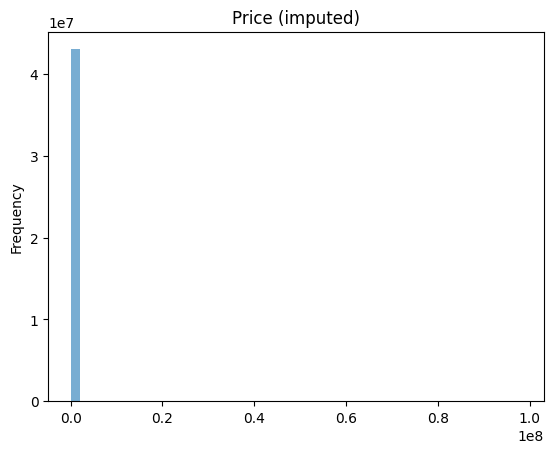

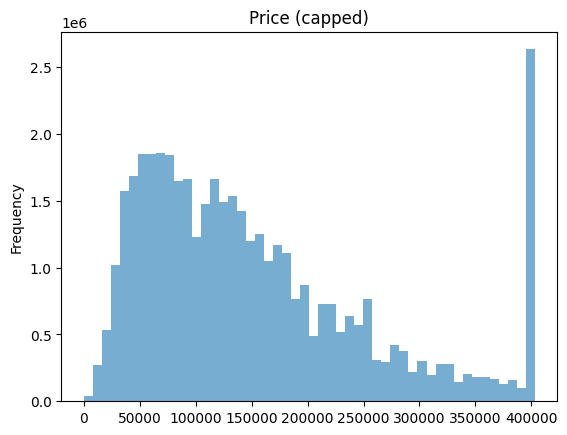

In [5]:

if "price_imputed" in df.columns:
    q1, q3 = df["price_imputed"].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    df["price_capped"] = df["price_imputed"].clip(lower=lo, upper=hi)
    df["price_imputed"].plot(kind="hist", bins=50, alpha=0.6, title="Price (imputed)"); plt.show()
    df["price_capped"].plot(kind="hist", bins=50, alpha=0.6, title="Price (capped)"); plt.show()


### Features

In [6]:

df["is_new_build"] = False
for c in df.columns:
    if "new" in c and df[c].dtype == "object":
        df["is_new_build"] = df[c].str.contains("new", case=False, na=False)
        break

if set(["year","month"]).issubset(df.columns):
    df["year_month"] = (
        df["year"].astype("Int64").astype("string").str.zfill(4) + "-" +
        df["month"].astype("Int64").astype("string").str.zfill(2)
    )
df.head()


,transaction_unique_identifier,price,date_of_transfer,property_type,oldnew,duration,towncity,district,county,ppdcategory_type,record_status__monthly_file_only,year,month,region,price_imputed,price_capped,is_new_build,year_month
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000.0,1995-08-18,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,A,1995,8,GREATER MANCHESTER,25000.0,25000.0,False,1995-08
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500.0,1995-08-09,S,N,F,GRAYS,THURROCK,THURROCK,A,A,1995,8,THURROCK,42500.0,42500.0,False,1995-08
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000.0,1995-06-30,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,A,1995,6,SOMERSET,45000.0,45000.0,False,1995-06
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150.0,1995-11-24,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,A,1995,11,BEDFORDSHIRE,43150.0,43150.0,False,1995-11
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899.0,1995-06-23,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,A,1995,6,WEST YORKSHIRE,18899.0,18899.0,False,1995-06


### Correlations

In [7]:

num_cols = df.select_dtypes(include=["number"]).columns.tolist()
corr = df[num_cols].corr(numeric_only=True)
if "price_capped" in corr.columns:
    corr["price_capped"].sort_values(ascending=False).head(10)
else:
    corr


### Save EDA preview CSV

In [8]:

preview_path = PROC_DIR / "housing_eda_sample.csv"
df.sample(min(100_000, len(df))).to_csv(preview_path, index=False)
print("Wrote preview:", preview_path)


Wrote preview: D:\Projects\cloud-Serfers\data\housing\housing_eda_sample.csv
